<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.lines as mlines

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
#identify the categories within MSZoning
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [5]:
#Part 2 - remove any non residential houses from the data set
residential = ['RL', 'RM', 'RH']
df = house[house['MSZoning'].isin(residential)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385 entries, 0 to 1459
Data columns (total 81 columns):
Id               1385 non-null int64
MSSubClass       1385 non-null int64
MSZoning         1385 non-null object
LotFrontage      1134 non-null float64
LotArea          1385 non-null int64
Street           1385 non-null object
Alley            65 non-null object
LotShape         1385 non-null object
LandContour      1385 non-null object
Utilities        1385 non-null object
LotConfig        1385 non-null object
LandSlope        1385 non-null object
Neighborhood     1385 non-null object
Condition1       1385 non-null object
Condition2       1385 non-null object
BldgType         1385 non-null object
HouseStyle       1385 non-null object
OverallQual      1385 non-null int64
OverallCond      1385 non-null int64
YearBuilt        1385 non-null int64
YearRemodAdd     1385 non-null int64
RoofStyle        1385 non-null object
RoofMatl         1385 non-null object
Exterior1st      1385 non-n

In [6]:
#drop ID column
df.drop(['Id'], axis=1,inplace=True)

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
numeric_data = df.select_dtypes(include=[np.number])
cat_data = df.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in the data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 37 numeric and 43 categorical columns in the data


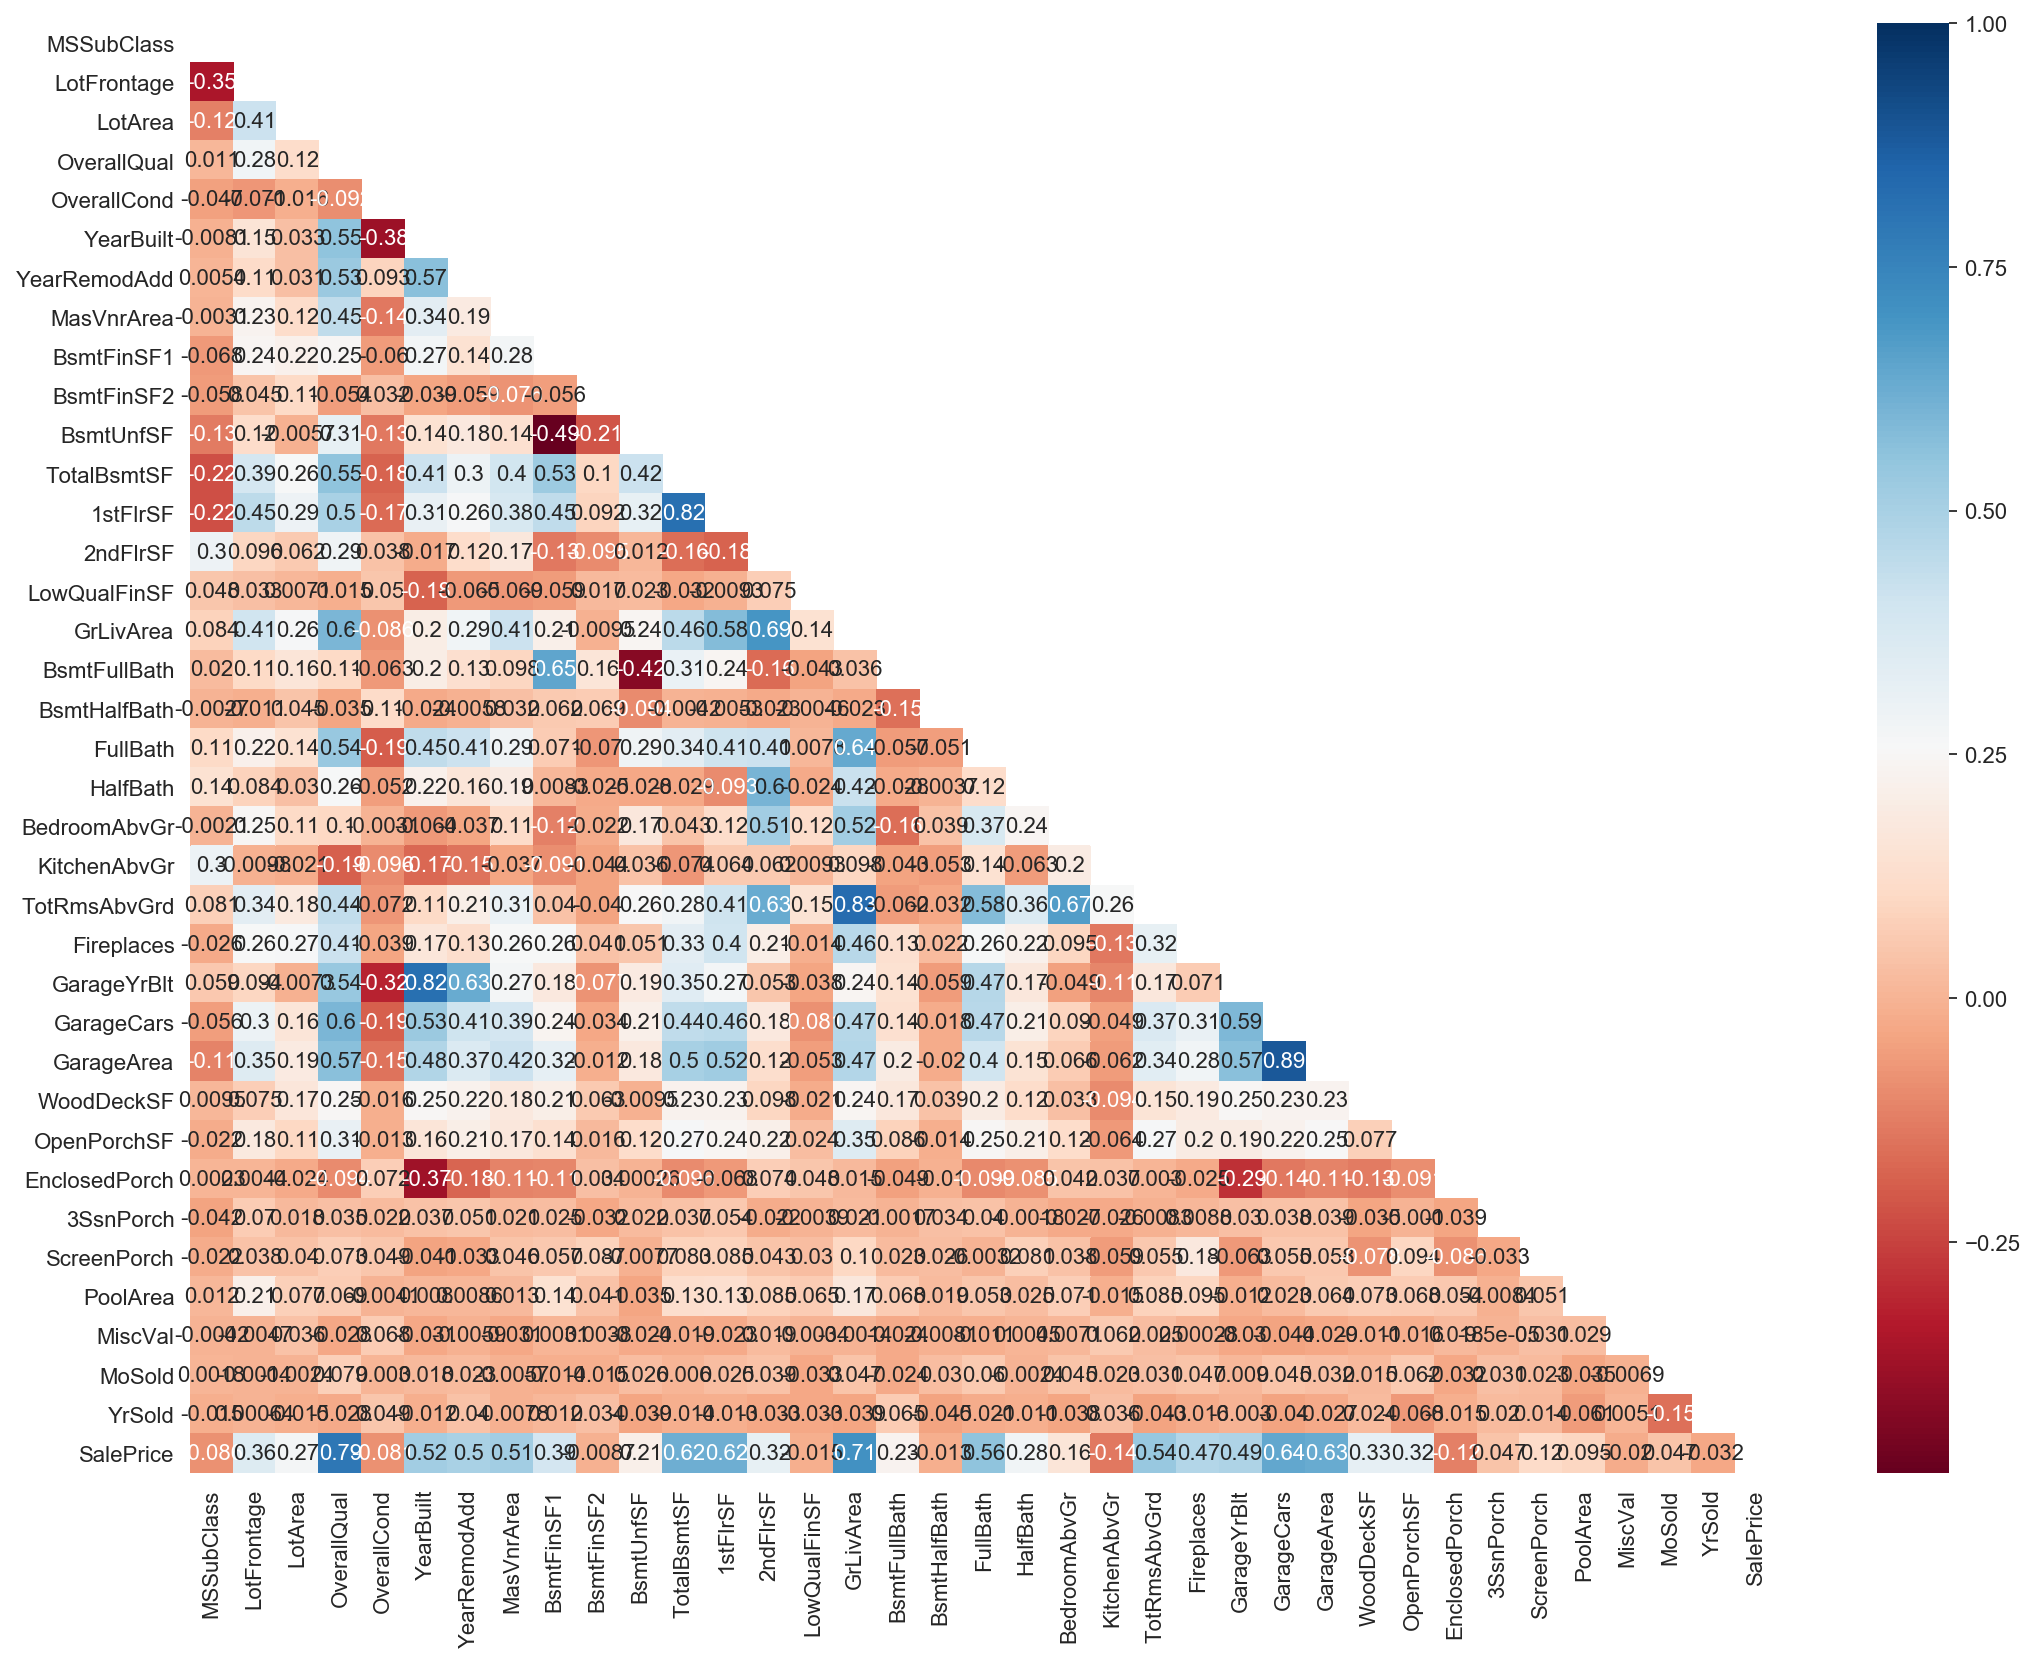

In [8]:
#correlation plot of numeric data
plt.figure(figsize=(16,12), dpi = 80)
corr = numeric_data.corr()
#mask top triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(numeric_data.corr(),mask=mask, annot=True, cmap='RdBu')

In [9]:
#examine the spread of sale prices
df.SalePrice.describe()

count      1385.000000
mean     180136.283032
std       79906.363281
min       37900.000000
25%      129000.000000
50%      160000.000000
75%      212900.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [10]:
#show all missing data
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1378,0.994946
MiscFeature,1333,0.962455
Alley,1320,0.953069
Fence,1108,0.800000
FireplaceQu,641,0.462816
LotFrontage,251,0.181227
GarageType,79,0.057040
GarageCond,79,0.057040
GarageFinish,79,0.057040
GarageQual,79,0.057040


In [11]:
print(df.LotFrontage.mean())
print(df.LotFrontage.median())
#replace values for LotFrontage with median, since mean and median are similar

70.58377425044091
70.0


In [12]:
#replace values with median
median = df.LotFrontage.median()
df.LotFrontage.fillna(value=median,inplace=True)

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


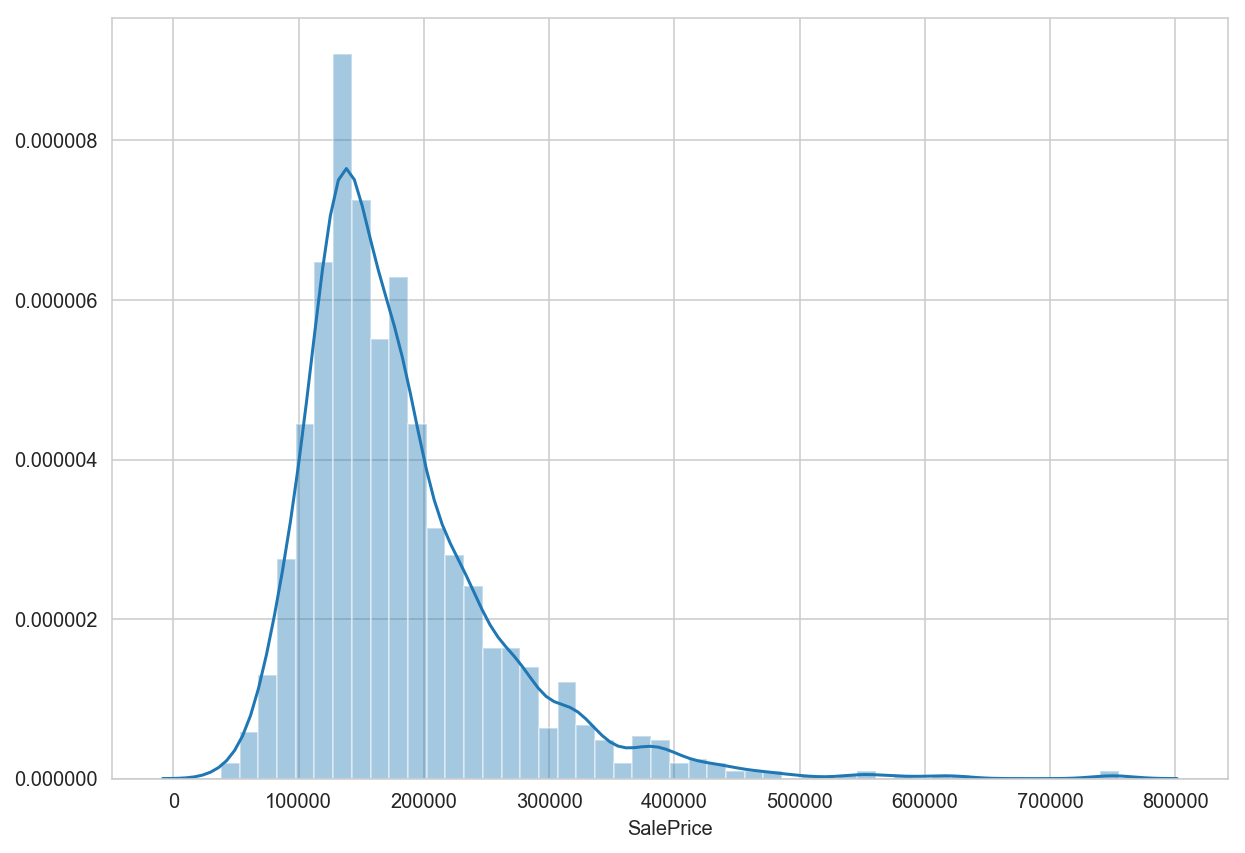

In [13]:
#take a look at the Sale Price distribution
plt.figure(figsize=(10,7))
sns.distplot(df.SalePrice)

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


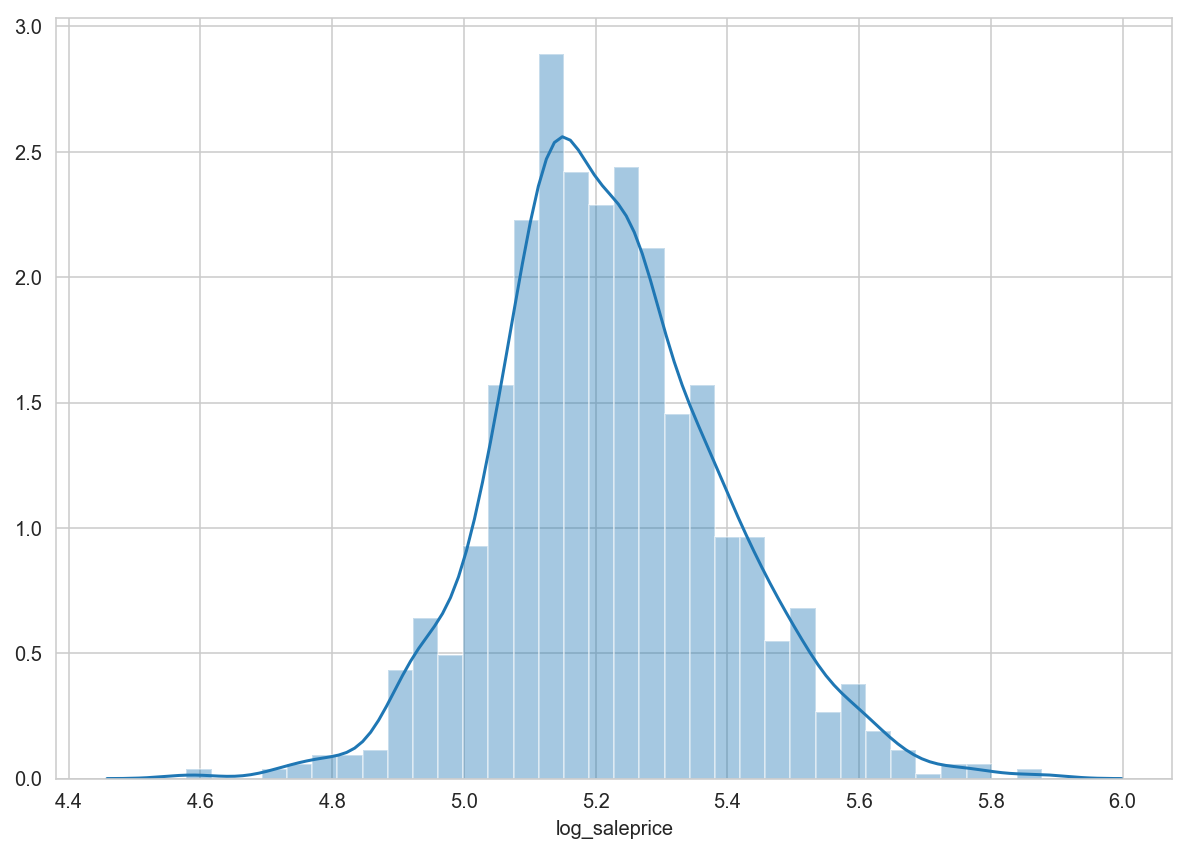

In [14]:
#distribution is skewed so we'll take a log of sale price
log_saleprice=np.log10(df.SalePrice)
df['log_saleprice']=log_saleprice

#Plot the distribution
plt.figure(figsize=(10,7))
sns.distplot(df['log_saleprice'])

In [15]:
# #create boxplots for vizualizing categorical variables
# def boxplot(x,y,**kwargs):
#             sns.boxplot(x=x,y=y)
#             x = plt.xticks(rotation=90)

# cat = [f for f in df.columns if df.dtypes[f] == 'object']

# p = pd.melt(df, id_vars='SalePrice', value_vars=cat)
# g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(boxplot, 'value','SalePrice')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

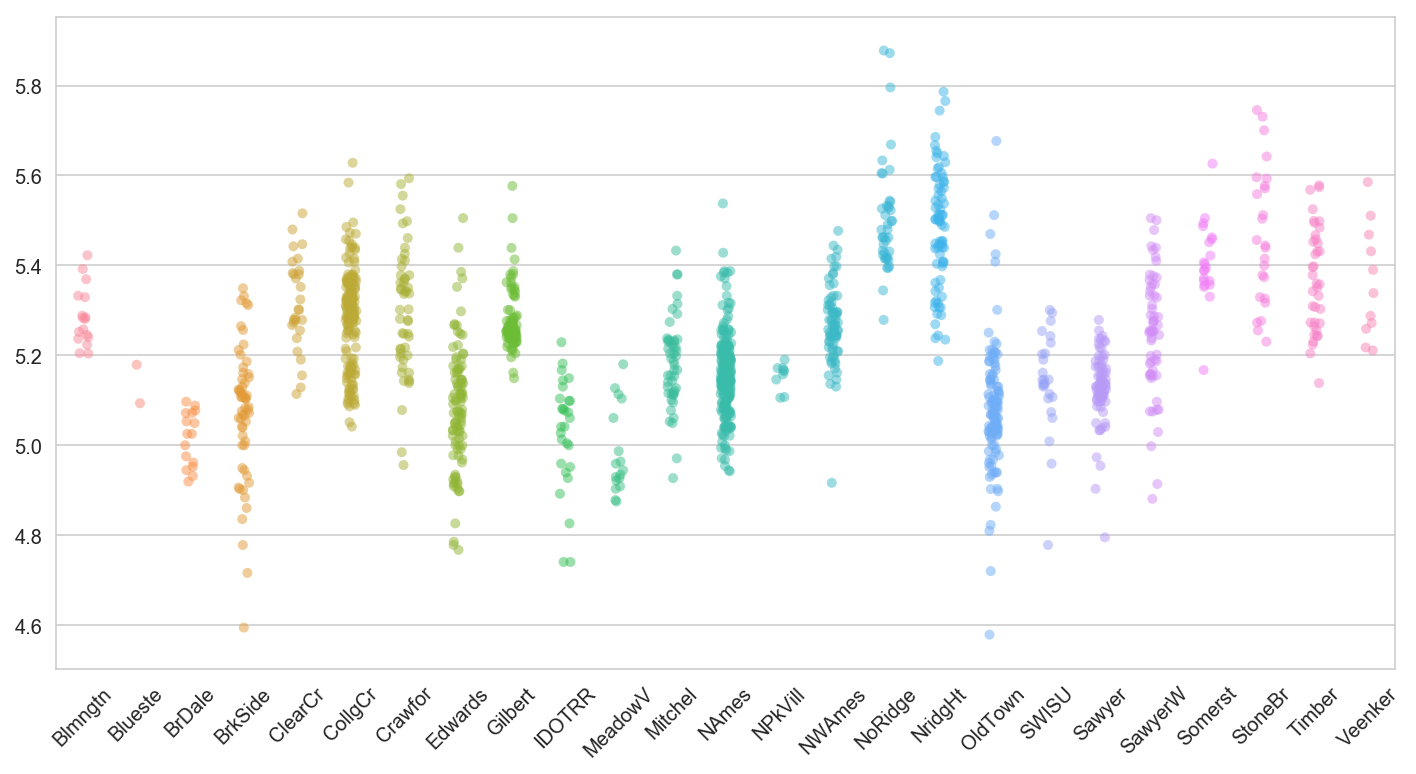

In [16]:
#lets look at the price distribution between neighborhoods
f,ax=plt.subplots(1,1,figsize=(12,6))

sns.stripplot(x = df.Neighborhood.values, y = df.log_saleprice.values,
              order = np.sort(df.Neighborhood.unique()),
              jitter=0.1, alpha=0.5)
 
plt.xticks(rotation=45)

In [17]:
#lets ort the sale price by mean to see how different neighbohoods compare against each other
Neighborhood_meanSP = \
    df.groupby('Neighborhood')['SalePrice'].mean()
 
Neighborhood_meanSP = Neighborhood_meanSP.sort_values()

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

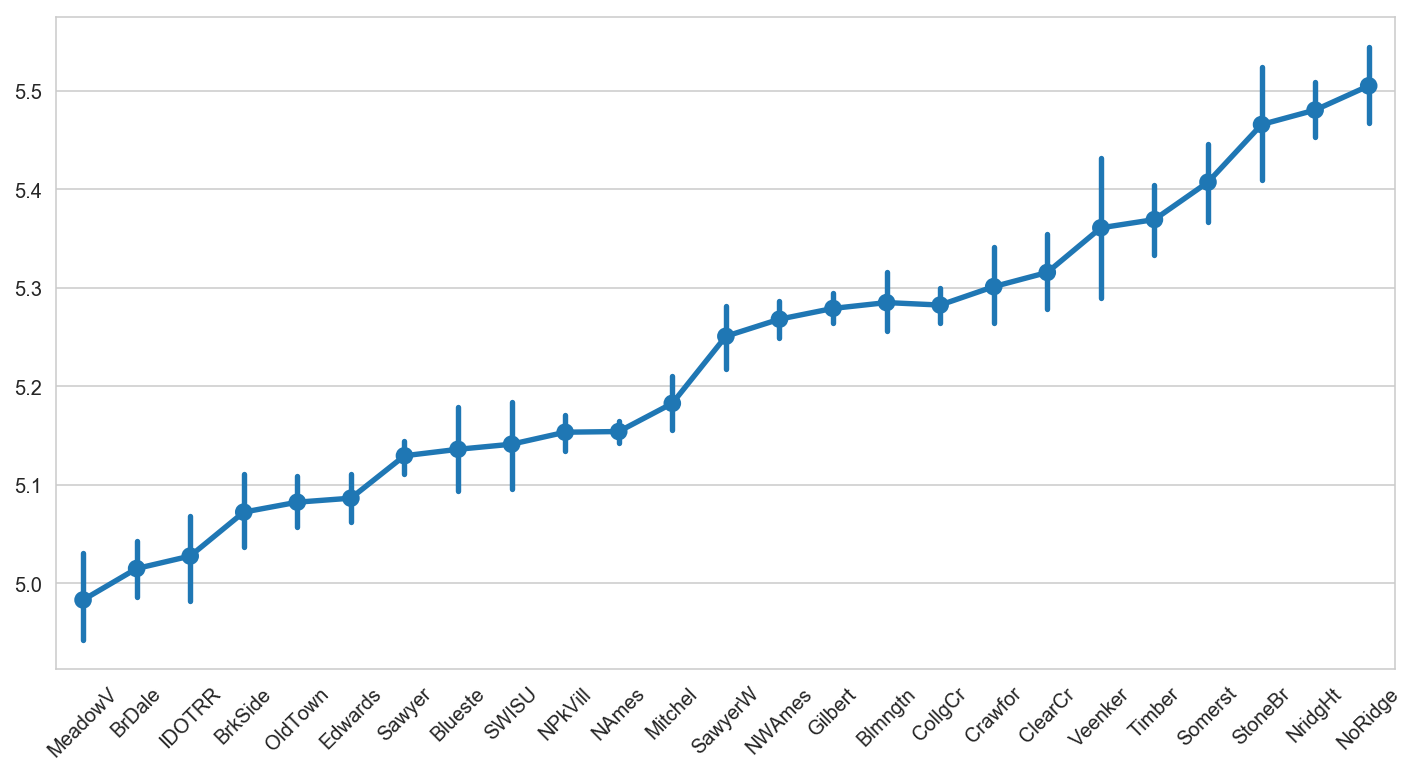

In [18]:
#plot the mean sale price by neighborhoods
f,ax=plt.subplots(1,1,figsize=(12,6))

sns.pointplot(x = df.Neighborhood.values, y = df.log_saleprice.values,
              order = Neighborhood_meanSP.index)
 
plt.xticks(rotation=45)

In [19]:
#Lets look at the missing values in the data set

def count_missing(data):
    null_cols = data.columns[data.isnull().any(axis=0)]
    X_null = data[null_cols].isnull().sum()
    X_null = X_null.sort_values(ascending=False)
    print(X_null)


count_missing(df)

PoolQC          1378
MiscFeature     1333
Alley           1320
Fence           1108
FireplaceQu      641
GarageCond        79
GarageQual        79
GarageFinish      79
GarageYrBlt       79
GarageType        79
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         5
MasVnrType         5
Electrical         1
dtype: int64


In [20]:
# for categorical features where there is a valid reason for missing values 
# (ie houses with no pool or fence and are reflected as such), replace with "None"

catfeats_fillnaNone = \
    ['Alley',
    'BsmtCond','BsmtQual','BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature']
 
df.loc[:,catfeats_fillnaNone] = \
    df[catfeats_fillnaNone].fillna('None')

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
#for numerical features with similar reasons, replace with zero
numfeats_fillnazero = \
    ['BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF',
     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
     'GarageArea', 'GarageCars']
 
df.loc[:,numfeats_fillnazero] = \
    df[numfeats_fillnazero].fillna(0)

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [22]:
#fill garage yr blt with year built data
df.loc[:,'GarageYrBlt'] = \
    df['GarageYrBlt'].fillna(df.YearBuilt)

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
#fill MasVnrArea with median
df.loc[:,'MasVnrArea'] = \
    df['MasVnrArea'].fillna(df['MasVnrArea'].median())

/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
#Lets look at the remaining missing values in the data set

def count_missing(data):
    null_cols = data.columns[data.isnull().any(axis=0)]
    X_null = data[null_cols].isnull().sum()
    X_null = X_null.sort_values(ascending=False)
    print(X_null)


count_missing(df)

MasVnrType    5
Electrical    1
dtype: int64


In [25]:
#convert categorical features to binary values
df = pd.get_dummies(df)

In [26]:
df.columns.values

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'log_saleprice', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave',
       'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig

df.SaleType.value_counts()

In [27]:
# df.SaleCondition.value_counts()

In [28]:
#Lotshape looks ok
# df.LotShape.value_counts()

In [29]:
# #Landcontour looks ok
# df.LandContour.value_counts()

In [30]:
# #to drop Utilities since there is only 1 property with no sewage system and can be considered an outlier. 
# df.Utilities.value_counts()

In [31]:
# df.LotConfig.value_counts()

df.Neighborhood.value_counts()

df.Condition1.value_counts()

df.YrSold.value_counts()

In [32]:
fixed_features = df[['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 
    'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave',
       'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd',
       'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtExposure_None', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None',
       'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_COD',]]

In [33]:
# #identify fixed features that can predict the price
# fixed_features = df[['Street_Grvl', 'Street_Pave',
#        'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1',
#        'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
#        'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
#        'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
#        'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
#        'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
#        'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
#        'Neighborhood_BrDale', 'Neighborhood_BrkSide',
#        'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
#        'Neighborhood_Crawfor', 'Neighborhood_Edwards',
#        'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
#        'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
#        'Neighborhood_NAmes', 'Neighborhood_NPkVill',
#        'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
#        'Neighborhood_NridgHt', 'Neighborhood_OldTown',
#        'Neighborhood_SWISU', 'Neighborhood_Sawyer',
#        'Neighborhood_SawyerW', 'Neighborhood_Somerst',
#        'Neighborhood_StoneBr', 'Neighborhood_Timber',
#        'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr',
#        'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
#        'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
#        'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr',
#        'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
#        'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn']]

In [34]:
df.Street_Grvl.value_counts()

0    1381
1       4
Name: Street_Grvl, dtype: int64

In [35]:
X = fixed_features
y = df['log_saleprice']

X_train = (X[df.YrSold< 2010])
X_test = (X[df.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y[df.YrSold< 2010])
y_test = np.ravel(y[df.YrSold == 2010])

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [36]:
# Importing dependencies for modelling # 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn import metrics
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [37]:
# fit a linear model
lm = linear_model.LinearRegression()
model = lm.fit(Xs_train, y_train)
predictions = lm.predict(Xs_test)
print("Model Score on Train Set:", model.score(Xs_train, y_train))
print("Model Score on Test Set:", model.score(Xs_test, y_test),'\n')
scores = cross_val_score(lm, Xs_train, y_train, cv=10)
print(scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

Model Score on Train Set: 0.882809889142107
Model Score on Test Set: 0.8796229629538178 

[ 8.83644506e-01  8.78029331e-01 -1.03292643e+26 -1.55086069e+26
  8.56236023e-01 -7.21052023e+16 -1.64661586e+24  8.14638532e-01
 -6.58727674e+23 -5.90529997e+24]
Mean: -2.6658935549089738e+25 Std: 5.258525294884231e+25
RMSE: 0.05998729515195485


Text(0,0.5,'Predictions')

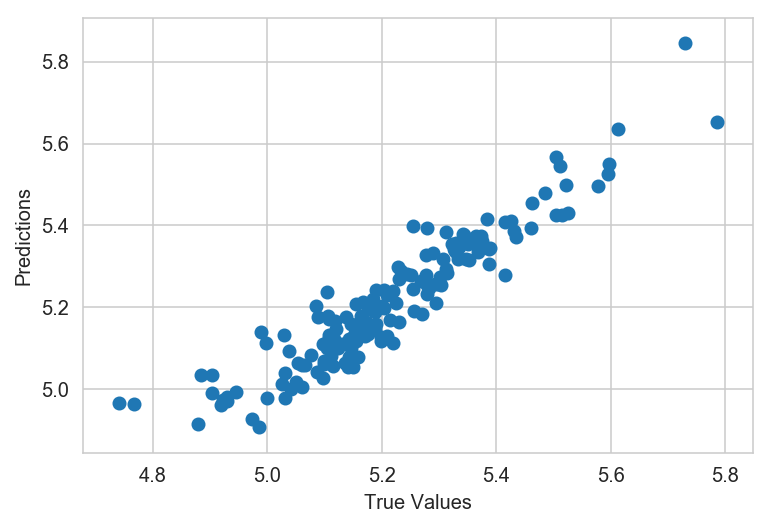

In [38]:
# compared predicted y values against actual y test values
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [39]:
model = sm.OLS(y_train, Xs_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.109
Method:                 Least Squares   F-statistic:                  0.008636
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               1.00
Time:                        14:22:29   Log-Likelihood:                -3750.6
No. Observations:                1221   AIC:                             7743.
Df Residuals:                    1100   BIC:                             8361.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0041      0.792     -0.005      0.996      -1.559       1.551
x2            -0.0068      0.234     -0.029      0.977      -0.465       0.451
x3             0.0105      0.253      0.042      0.967      -0.485       0.506
x4             0.0211      0.556      0.038      0.970      -1.069       1.112
x5            -0.0015      0.449     -0.003      0.997      -0.882       0.879
x6             0.0234      1.811      0.013      0.990      -3.530       3.577
x7             0.0268      1.962      0.014      0.989      -3.823       3.877
x8             0.0302      2.459      0.012      0.990      -4.794       4.854
x9             0.0136      0.196      0.069      0.945      -0.372       0.399
x10            0.0049      0.174      0.028      0.977      -0.336       0.346
x11            0.0117      0.303      0.039      0.969      -0.582       0.605
x12            0.0068      0.266      0.025      0.980      -0.516       0.529
x13           -0.0035      0.272     -0.013      0.990      -0.537       0.530
x14           -0.0108      0.292     -0.037      0.970      -0.585       0.563
x15            0.0107      0.390      0.027      0.978      -0.754       0.775
x16            0.0111      0.214      0.052      0.959      -0.409       0.431
x17           -0.0001      0.375     -0.000      1.000      -0.735       0.735
x18            0.0206      0.418      0.049      0.961      -0.799       0.840
x19            0.0016      0.428      0.004      0.997      -0.839       0.842
x20            0.0062      0.186      0.033      0.973      -0.359       0.372
x21            0.0039      0.192      0.021      0.984      -0.372       0.380
x22            0.0035      0.189      0.019      0.985      -0.367       0.374
x23            0.0055      0.168      0.033      0.974      -0.325       0.336
x24            0.0099      0.179      0.055      0.956      -0.341       0.361
x25           -0.0016      0.185     -0.008      0.993      -0.365       0.362
x26            0.0137      1.198      0.011      0.991      -2.337       2.365
x27           -0.0004      0.175     -0.002      0.998      -0.344       0.343
x28            0.0013      0.166      0.008      0.994      -0.324       0.327
x29           -0.0012      0.185     -0.006      0.995      -0.364       0.361
x30           -0.0014      0.093     -0.015      0.988      -0.183       0.180
x31            0.0014      0.093      0.015      0.988      -0.180       0.183
x32           -0.0015      0.120     -0.013      0.990      -0.237       0.234
x33           -0.0025      0.101     -0.025      0.980      -0.200       0.195
x34            0.0078      0.157      0.050      0.960      -0.300       0.315
x35           -0.0007      0.102     -0.007      0.994      -0.200       0.199
x36            0.0024      0.167      0.015      0.988      -0.326       0.331
x3

In [40]:
Xs_train2 = np.concatenate([Xs_train, np.ones((Xs_train.shape[0],1))], axis=1)
model = sm.OLS(y_train, Xs_train2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     68.82
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:22:29   Log-Likelihood:                 1734.3
No. Observations:                1221   AIC:                            -3225.
Df Residuals:                    1099   BIC:                            -2602.
Df Model:                         121                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0041      0.009     -0.462      0.644      -0.022       0.013
x2            -0.0068      0.003     -2.613      0.009      -0.012      -0.002
x3             0.0105      0.003      3.711      0.000       0.005       0.016
x4             0.0211      0.006      3.395      0.001       0.009       0.033
x5            -0.0015      0.005     -0.296      0.767      -0.011       0.008
x6             0.0234      0.020      1.153      0.249      -0.016       0.063
x7             0.0268      0.022      1.217      0.224      -0.016       0.070
x8             0.0302      0.028      1.098      0.272      -0.024       0.084
x9             0.0136      0.002      6.167      0.000       0.009       0.018
x10            0.0049      0.002      2.529      0.012       0.001       0.009
x11            0.0117      0.003      3.457      0.001       0.005       0.018
x12            0.0068      0.003      2.264      0.024       0.001       0.013
x13           -0.0035      0.003     -1.159      0.247      -0.009       0.002
x14           -0.0108      0.003     -3.303      0.001      -0.017      -0.004
x15            0.0107      0.004      2.441      0.015       0.002       0.019
x16            0.0111      0.002      4.631      0.000       0.006       0.016
x17           -0.0001      0.004     -0.034      0.973      -0.008       0.008
x18            0.0206      0.005      4.403      0.000       0.011       0.030
x19            0.0016      0.005      0.333      0.740      -0.008       0.011
x20            0.0062      0.002      2.980      0.003       0.002       0.010
x21            0.0039      0.002      1.834      0.067      -0.000       0.008
x22            0.0035      0.002      1.663      0.097      -0.001       0.008
x23            0.0055      0.002      2.919      0.004       0.002       0.009
x24            0.0099      0.002      4.932      0.000       0.006       0.014
x25           -0.0016      0.002     -0.758      0.449      -0.006       0.002
x26            0.0137      0.013      1.024      0.306      -0.013       0.040
x27           -0.0004      0.002     -0.182      0.856      -0.004       0.003
x28            0.0013      0.002      0.681      0.496      -0.002       0.005
x29           -0.0012      0.002     -0.578      0.563      -0.005       0.003
x30           -0.0014      0.001     -1.357      0.175      -0.003       0.001
x31            0.0014      0.001      1.357      0.175      -0.001       0.003
x32           -0.0015      0.001     -1.118      0.264      -0.004       0.001
x33           -0.0025      0.001     -2.211      0.027      -0.005      -0.000
x34            0.0078      0.002      4.463      0.000       0.004       0.011
x35           -0.0007      0.001     -0.654      0.513      -0.003       0.001
x36            0.0024      0.002      1.304      0.192      -0.001       0.006
x3

In [41]:
## Ridge and Lasso ## 

# Finding optimal regularisation parameter for Ridge # 

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print("Ridge will be run at alpha = {:5.2f}".format(optimal_ridge.alpha_))

# Finding optimal regularisation parameter for Lasso # 

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("Lasso will be run at alpha = {:5.7f}".format(optimal_lasso.alpha_))

Ridge will be run at alpha = 596.36


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso will be run at alpha = 0.0016752


...................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished


In [42]:
def print_cross_val_results(model,name,Xs,y,folds=5):
    
    '''
        Takes a model, ie. instantiated class object, feature and target set and performs 
        5 fold cross validation using R^2 as a metric.
        
        Prints the scores, mean and std of the scores. 
        
    '''
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    
    # Compute cross val score # 
    
    scores = cross_val_score(model, Xs, y, cv=folds)
    
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

OLS = LinearRegression()
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso= Lasso(alpha=optimal_lasso.alpha_)

print_cross_val_results(OLS,"Linear Regression (train)",Xs_train,y_train)
print_cross_val_results(OLS,"Linear Regression (test)",Xs_test,y_test)
print_cross_val_results(ridge,"Ridge Regression (train)",Xs_train,y_train)
print_cross_val_results(ridge,"Ridge Regression (test)",Xs_test,y_test)
print_cross_val_results(lasso,"Lasso Regression (train)",Xs_train,y_train)
print_cross_val_results(lasso,"Lasso Regression (test)",Xs_test,y_test)

------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (train)
Cross-validated scores: [ 8.76020937e-01 -5.42036084e+24 -2.07632439e+19 -6.42552193e+24
 -1.49207655e+25]
Mean CV R2: -5.353333810333377e+24
Std CV R2: 5.477334624328479e+24
------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (test)
Cross-validated scores: [-1.83167300e+21 -1.35115273e+24 -5.20532202e+23 -2.16702562e+22
 -5.00283416e+22]
Mean CV R2: -3.89043041187236e+23
Std CV R2: 5.1822212089832225e+23
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (train)
Cross-validated scores: [0.87923977 0.82900828 0.83289652 0.84632112 0.76871802]
Mean CV R2: 0.8312367431615222
Std CV R2: 0.03591139234288857
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (test)
Cross-validated scores: [0.74189051 0.7330372  0.76769655 0.70954026 0.68960443]
Mean C

In [43]:
def act_pred_3_plots(models,names,X,y,color):
    '''
        Takes a list of 3 models, feature set and predictor set and returns an actual vs predicted 
        plot agains the target values. 
    '''
    
    fig=plt.figure(figsize=(15,5))
    
    # Square grid, 1 by 3 # 
    grid=131
    
    
    # Go through list of 3 models # 
    for model,name in zip(models,names):
        
        # Generate residuals #
        preds=model.fit(X,y).predict(X)
        ax=plt.subplot(grid)
        
        # Plot reisduals vs y first # 
        
        plt.scatter(preds,y,alpha=0.2,color=color)
        
        # Make it a square plot # 
        uplim=max(ax.get_xlim()+ax.get_ylim())
        lowlim=min(ax.get_xlim()+ax.get_ylim())
        ax.set_xlim(lowlim,uplim)
        ax.set_ylim(lowlim,uplim)
        
        # Add unit line # 
        lines=np.linspace(lowlim,uplim)
        line=mlines.Line2D(lines,lines,linestyle='--')
        ax.add_line(line)
        
        # Set title # 
        ax.set_title(name,fontsize=12)
        
        # Set axis labels # 

        ax.set_ylabel('Actual')
        ax.set_xlabel('Predicted')
        
        # Move on to the next plot # 
        grid+=1
        color = tuple([col+0.1 for col in color])
    
    fig.suptitle("Predicted vs Actual for various models",fontsize=16,fontweight='bold')
    
    plt.show()

In [44]:
def resid_3_plots(models,names,X,y,color):
    '''
        Takes a list of 3 models, feature set and predictor set and returns an residual vs predicted 
        plot. 
    '''
    
    fig=plt.figure(figsize=(15,5))
    # Square grid, 1 by 3 # 
    grid=131
    
    
    # Go through list of 3 models # 
    for model,name in zip(models,names):
        
        # Generate reisduals #
        preds=model.fit(X,y).predict(X)
        resids=y-preds
        ax=plt.subplot(grid)
        
        # Plot reisduals vs y first # 
        
        plt.scatter(preds,resids,alpha=0.2,color=color)
        
        # Add y=0 line # 
        uplim=max(ax.get_xlim())
        lowlim=min(ax.get_xlim())
        lines=np.linspace(lowlim,uplim)
        zeros=np.zeros(50)
        line=mlines.Line2D(lines,zeros,linestyle='--')
        ax.add_line(line)
        
        # Set title # 
        ax.set_title(name,fontsize=12)
        
        # Set labels # 
        ax.set_ylabel('Residuals')
        ax.set_xlabel('Predicted')
        
        # Move on to the next plot # 
        grid+=1
        color = tuple([col+0.1 for col in color])
    
    fig.suptitle("Residuals vs Predicted for various models",fontsize=16,fontweight='bold')
    
    plt.show()

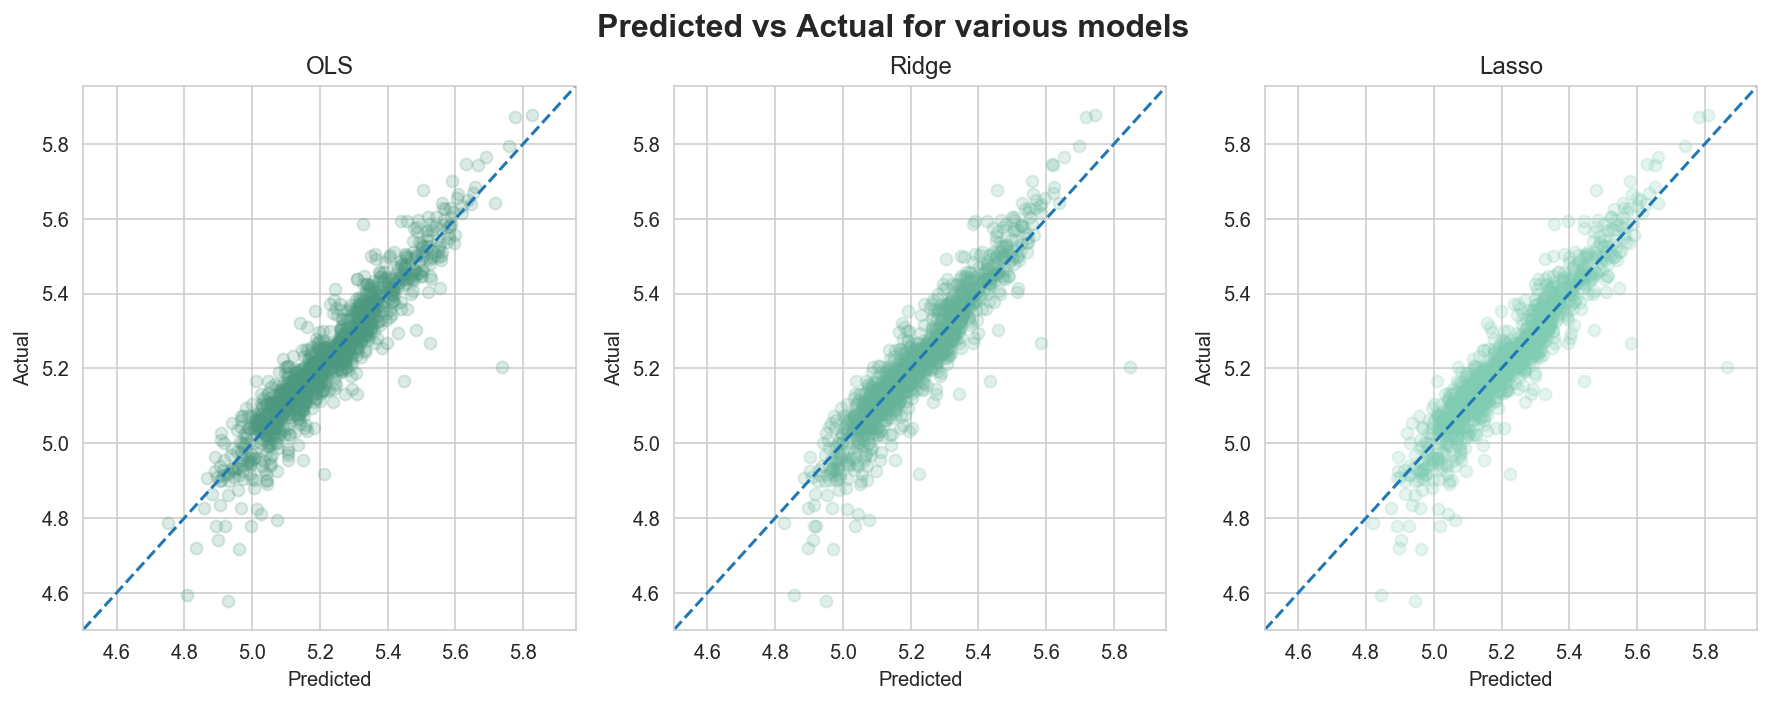

In [45]:
# Predicted vs actual, OLS Ridge and Lasso # 

models=[OLS,ridge,lasso]
names=["OLS","Ridge","Lasso"]
color=(0.3,0.6,0.5)
act_pred_3_plots(models,names,Xs_train,y_train,color)

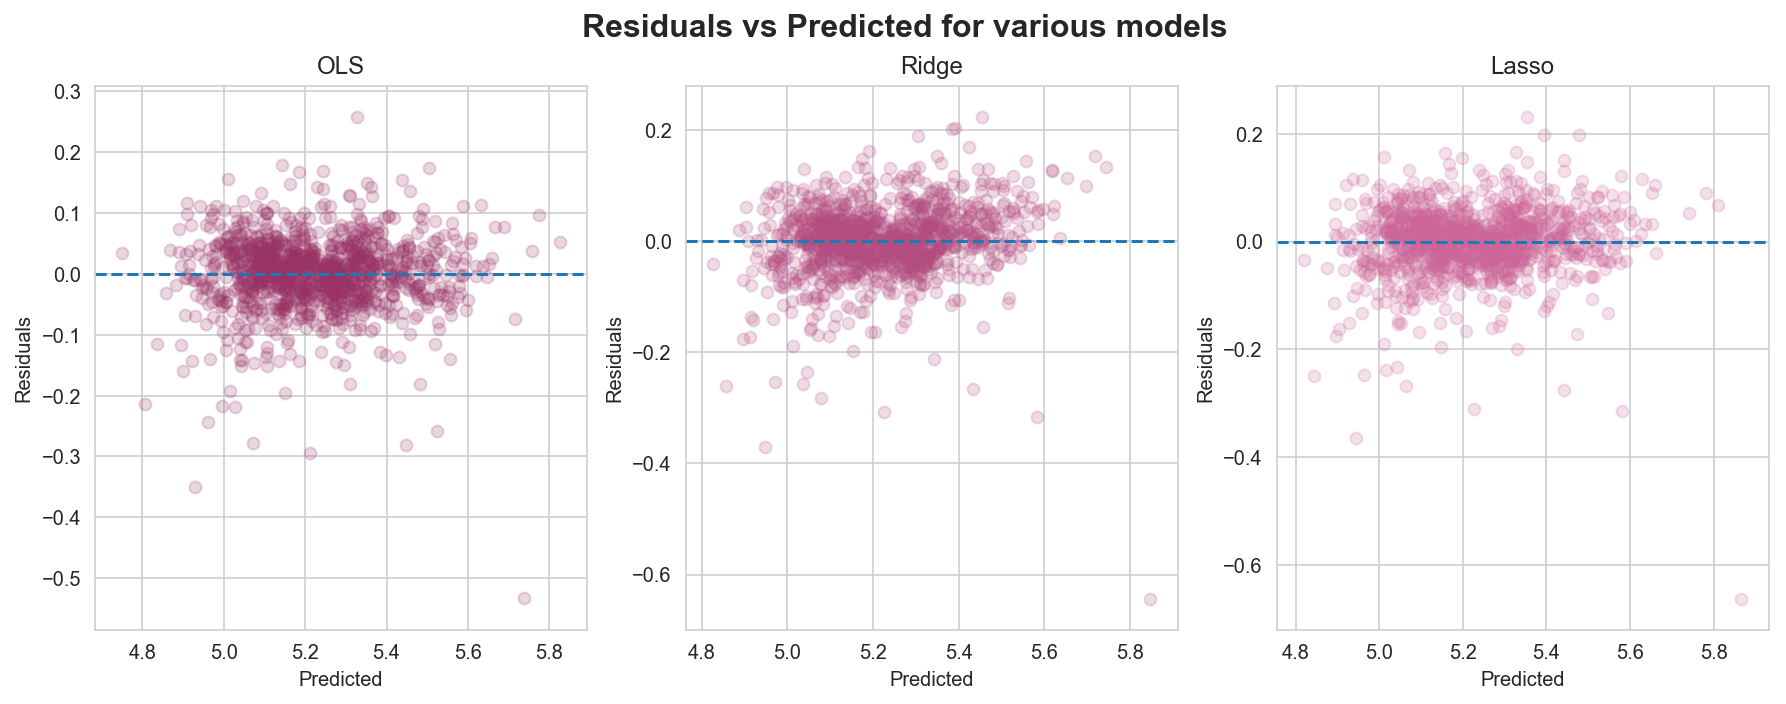

In [46]:
# Residual plot # 

color=(0.6,0.2,0.4)
resid_3_plots(models,names,Xs_train,y_train,color)

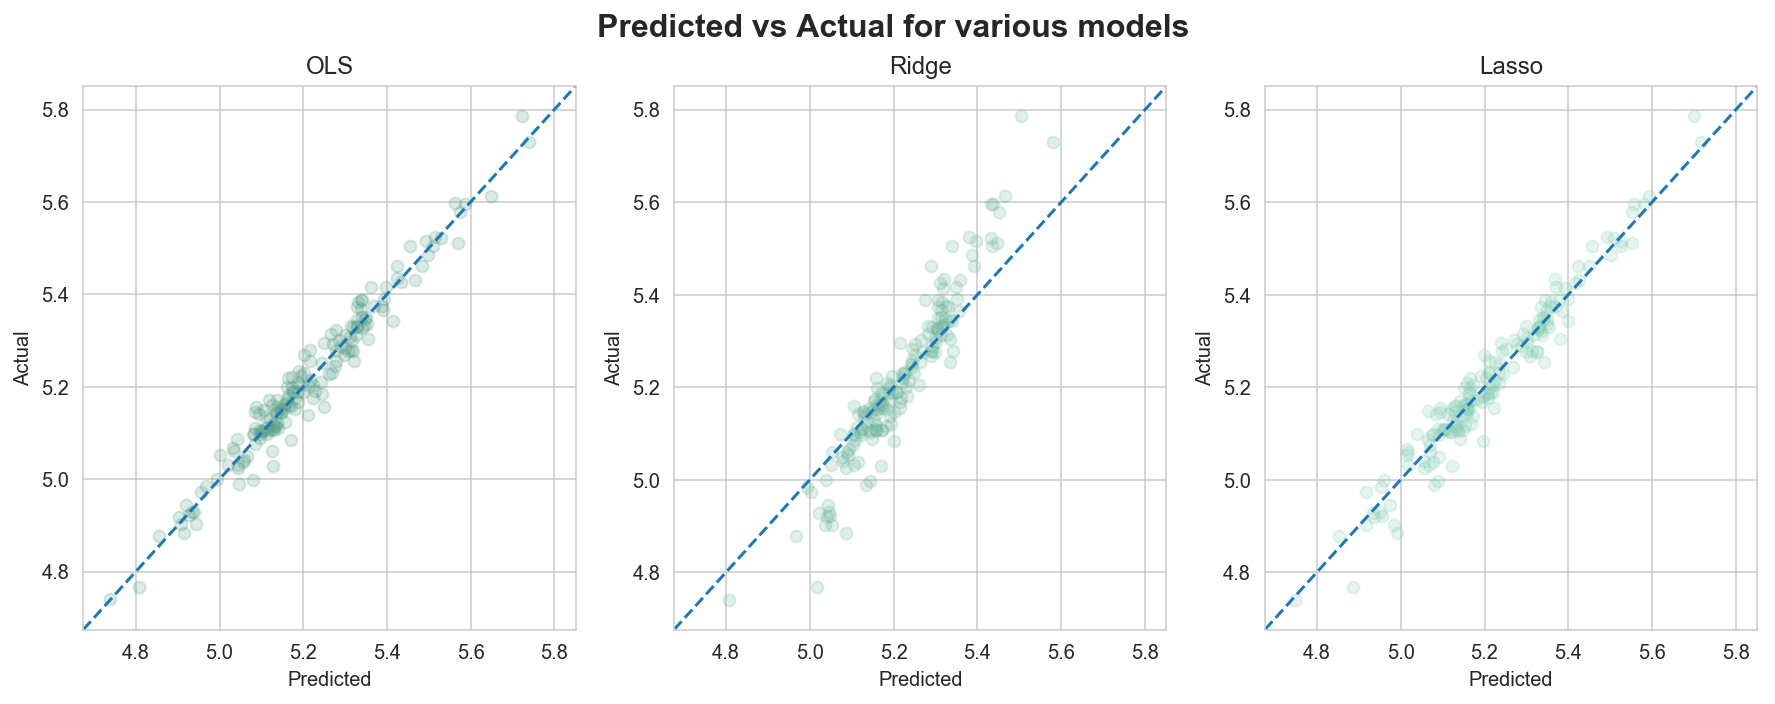

In [47]:
# Predicted vs actual, OLS Ridge and Lasso # 

models=[OLS,ridge,lasso]
names=["OLS","Ridge","Lasso"]
color=(0.3,0.6,0.5)
act_pred_3_plots(models,names,Xs_test,y_test,color)

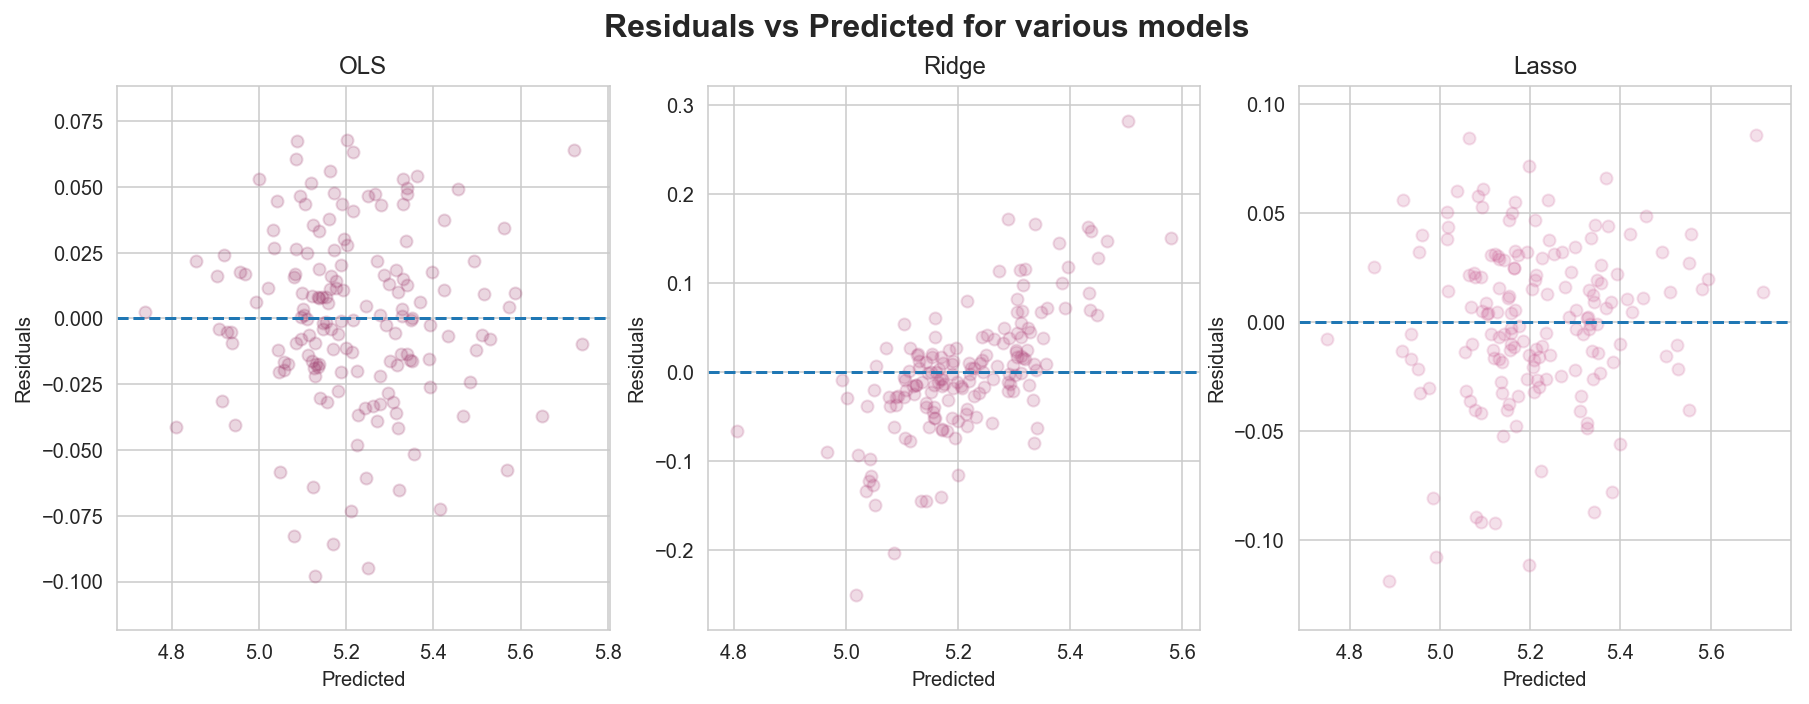

In [48]:
# Residual plot # 

color=(0.6,0.2,0.4)
resid_3_plots(models,names,Xs_test,y_test,color)

In [49]:
#Lasso regression performs the best. Based on the plots, the model seems to be predicting well. 

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [50]:
#create a model with all features and compare the difference with the first model
#all features were used apart from 'MoSold', 'YrSold' which are not feature sof the house
       
all_features = df[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave',
       'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable',
       'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard',
       'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_AsbShng', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsbShng',
       'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
       'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc',
       'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood',
       'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA',
       'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po',
       'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd',
       'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtExposure_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ',
       'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None',
       'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ',
       'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav',
       'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa',
       'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N',
       'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd',
       'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2',
       'Functional_Min1', 'Functional_Min2', 'Functional_Mod',
       'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex',
       'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None',
       'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None',
       'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa',
       'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA',
       'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex',
       'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_None', 'Fence_GdPrv',
       'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None',
       'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_COD',
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial']]

In [51]:
X = all_features
y = df['log_saleprice']

X_train = (X[df.YrSold< 2010])
X_test = (X[df.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y[df.YrSold< 2010])
y_test = np.ravel(y[df.YrSold == 2010])

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [52]:
# fit a linear model
lm = linear_model.LinearRegression()
model = lm.fit(Xs_train, y_train)
predictions = lm.predict(Xs_test)
print("Model Score on Train Set:", model.score(Xs_train, y_train))
print("Model Score on Test Set:", model.score(Xs_test, y_test),'\n')
scores = cross_val_score(lm, Xs_train, y_train, cv=10)
print(scores)
print("Mean:", np.mean(scores), "Std:", np.std(scores))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))

Model Score on Train Set: 0.9467306968606359
Model Score on Test Set: -9.196301450811013e+24 

[-1.02768660e+25 -1.05713781e+25 -2.55063744e+25 -4.62730149e+24
 -1.88209238e+23 -5.23875337e+24 -2.37899923e+21  9.16789071e-01
 -2.32496519e+25 -1.73899391e+25]
Mean: -9.705085247730822e+24 Std: 9.043807402090076e+24
RMSE: 524317139390.93414


Text(0,0.5,'Predictions')

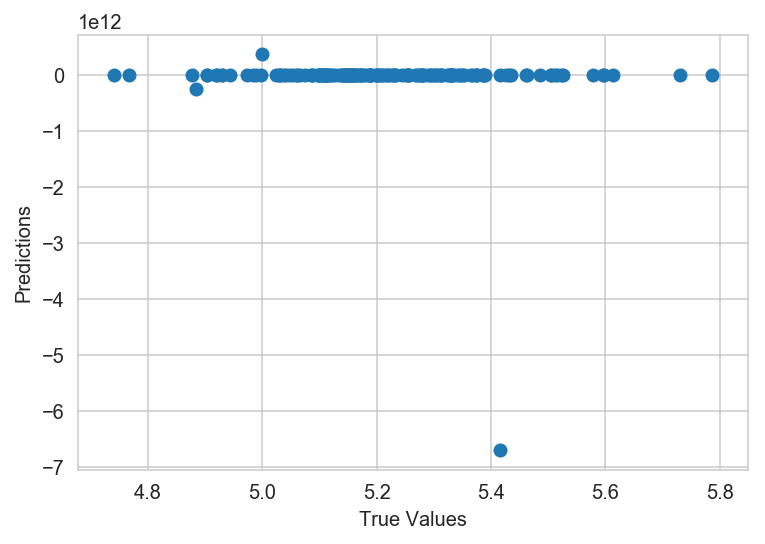

In [53]:
# compared predicted y values against actual y test values
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [54]:
Xs_train2 = np.concatenate([Xs_train, np.ones((Xs_train.shape[0],1))], axis=1)
model = sm.OLS(y_train, Xs_train2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     69.81
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:22:44   Log-Likelihood:                 2213.8
No. Observations:                1221   AIC:                            -3930.
Df Residuals:                     972   BIC:                            -2658.
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0074      0.007     -1.059      0.290      -0.021       0.006
x2             0.0031      0.002      1.460      0.145      -0.001       0.007
x3             0.0132      0.002      5.476      0.000       0.008       0.018
x4             0.0265      0.003      8.645      0.000       0.020       0.032
x5             0.0189      0.002      9.158      0.000       0.015       0.023
x6             0.0227      0.005      4.240      0.000       0.012       0.033
x7             0.0083      0.002      3.352      0.001       0.003       0.013
x8             0.0023      0.002      0.957      0.339      -0.002       0.007
x9             0.0123      0.002      5.289      0.000       0.008       0.017
x10            0.0040      0.003      1.463      0.144      -0.001       0.009
x11            0.0007      0.002      0.363      0.717      -0.003       0.005
x12            0.0149      0.003      4.650      0.000       0.009       0.021
x13            0.0158      0.004      4.453      0.000       0.009       0.023
x14            0.0205      0.004      5.619      0.000       0.013       0.028
x15           -0.0008      0.002     -0.378      0.706      -0.005       0.003
x16            0.0281      0.003      9.979      0.000       0.023       0.034
x17            0.0063      0.002      2.812      0.005       0.002       0.011
x18            0.0018      0.002      1.111      0.267      -0.001       0.005
x19            0.0061      0.003      2.321      0.021       0.001       0.011
x20            0.0058      0.002      2.475      0.013       0.001       0.010
x21            0.0014      0.002      0.559      0.576      -0.003       0.006
x22           -0.0035      0.003     -1.279      0.201      -0.009       0.002
x23            0.0022      0.003      0.641      0.522      -0.005       0.009
x24            0.0029      0.004      0.820      0.412      -0.004       0.010
x25           -0.0021      0.003     -0.624      0.533      -0.009       0.005
x26            0.0063      0.004      1.696      0.090      -0.001       0.014
x27            0.0087      0.004      2.339      0.020       0.001       0.016
x28            0.0068      0.002      4.205      0.000       0.004       0.010
x29            0.0035      0.002      2.080      0.038       0.000       0.007
x30            0.0023      0.002      1.342      0.180      -0.001       0.006
x31            0.0023      0.001      1.616      0.107      -0.000       0.005
x32            0.0062      0.002      3.990      0.000       0.003       0.009
x33            0.0216      0.020      1.080      0.280      -0.018       0.061
x34            0.0036      0.011      0.336      0.737      -0.017       0.024
x35           -0.0005      0.001     -0.370      0.711      -0.003       0.002
x36           -0.0024      0.001     -1.660      0.097      -0.005       0.000
x3

In [55]:
## Ridge and Lasso ## 

# Finding optimal regularisation parameter for Ridge # 

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print("Ridge will be run at alpha = {:5.2f}".format(optimal_ridge.alpha_))

# Finding optimal regularisation parameter for Lasso # 

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("Lasso will be run at alpha = {:5.7f}".format(optimal_lasso.alpha_))

Ridge will be run at alpha = 596.36


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso will be run at alpha = 0.0021952


In [56]:
def print_cross_val_results(model,name,Xs,y,folds=5):
    
    '''
        Takes a model, ie. instantiated class object, feature and target set and performs 
        5 fold cross validation using R^2 as a metric.
        
        Prints the scores, mean and std of the scores. 
        
    '''
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    
    # Compute cross val score # 
    
    scores = cross_val_score(model, Xs, y, cv=folds)
    
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

OLS = LinearRegression()
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso= Lasso(alpha=optimal_lasso.alpha_)

print_cross_val_results(OLS,"Linear Regression (train)",Xs_train,y_train)
print_cross_val_results(OLS,"Linear Regression (test)",Xs_test,y_test)
print_cross_val_results(ridge,"Ridge Regression (train)",Xs_train,y_train)
print_cross_val_results(ridge,"Ridge Regression (test)",Xs_test,y_test)
print_cross_val_results(lasso,"Lasso Regression (train)",Xs_train,y_train)
print_cross_val_results(lasso,"Lasso Regression (test)",Xs_test,y_test)

------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (train)
Cross-validated scores: [-1.38165997e+25 -6.15727756e+24 -2.54326300e+23 -1.54659111e+25
 -3.44055409e+25]
Mean CV R2: -1.401993110546504e+25
Std CV R2: 1.1567354807403352e+25
------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (test)
Cross-validated scores: [0.53636646 0.35448681 0.71174587 0.74025859 0.50791085]
Mean CV R2: 0.5701537140832122
Std CV R2: 0.1417829119158739
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (train)
Cross-validated scores: [0.92034761 0.87096037 0.88113624 0.90118486 0.79702538]
Mean CV R2: 0.8741308945968804
Std CV R2: 0.04212431339077536
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (test)
Cross-validated scores: [0.80934443 0.80188756 0.80702824 0.79389987 0.78371565]
Mean CV R2: 0.7991751484483212
Std CV 

In [57]:
# Lasso regression performs the best at 0.88 , which is pretty similar to the model with only fixed features
# so the renovatable features seem to contribute marginally to the sale price of the property 

In [58]:
#Lets look at the coefficients of the lasso model

In [59]:
# Look at lasso coefficients # 
lasso.fit(Xs_train,y_train)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
15,GrLivArea,0.054654,0.054654
3,OverallQual,0.036755,0.036755
123,RoofMatl_ClyTile,-0.028397,0.028397
5,YearBuilt,0.019771,0.019771
4,OverallCond,0.015983,0.015983
11,TotalBsmtSF,0.015116,0.015116
100,Condition2_PosN,-0.012428,0.012428
25,GarageCars,0.011097,0.011097
8,BsmtFinSF1,0.010149,0.010149
6,YearRemodAdd,0.008769,0.008769


In [60]:
# Look at lasso coefficients # 
lasso.fit(Xs_test,y_test)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(10)


,variable,coef,abs_coef
15,GrLivArea,0.048860,0.048860
3,OverallQual,0.027046,0.027046
5,YearBuilt,0.023236,0.023236
26,GarageArea,0.022056,0.022056
11,TotalBsmtSF,0.017567,0.017567
2,LotArea,0.013984,0.013984
294,SaleCondition_Abnorml,-0.013554,0.013554
166,ExterQual_Ex,0.012688,0.012688
8,BsmtFinSF1,0.012074,0.012074
177,Foundation_PConc,0.010854,0.010854


In [61]:
top10 = lasso_coefs.head(10)
top10 = [top10['variable']]
print(top10)

[15                 GrLivArea
3                OverallQual
5                  YearBuilt
26                GarageArea
11               TotalBsmtSF
2                    LotArea
294    SaleCondition_Abnorml
166             ExterQual_Ex
8                 BsmtFinSF1
177         Foundation_PConc
Name: variable, dtype: object]


In [62]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(len(lasso.coef_)))

Percent variables zeroed out: 0.7566666666666667


In [67]:
#run a model based on the top 10 features based on the training data set
top10_features = df[['GrLivArea', 'OverallQual', 'YearBuilt', 'OverallCond',
 'TotalBsmtSF', 'GarageCars','BsmtFinSF1', 'YearRemodAdd', 'Neighborhood_Crawfor', 'GarageArea']]

In [68]:
X = top10_features
y = df['log_saleprice']

X_train = (X[df.YrSold< 2010])
X_test = (X[df.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y[df.YrSold< 2010])
y_test = np.ravel(y[df.YrSold == 2010])

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [69]:
Xs_train2 = np.concatenate([Xs_train, np.ones((Xs_train.shape[0],1))], axis=1)
model = sm.OLS(y_train, Xs_train2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     659.5
Date:                Thu, 17 Jan 2019   Prob (F-statistic):               0.00
Time:                        14:27:33   Log-Likelihood:                 1560.4
No. Observations:                1221   AIC:                            -3099.
Df Residuals:                    1210   BIC:                            -3043.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0555      0.003     20.797      0.000       0.050       0.061
x2             0.0517      0.003     16.212      0.000       0.045       0.058
x3             0.0396      0.003     12.334      0.000       0.033       0.046
x4             0.0232      0.002      9.943      0.000       0.019       0.028
x5             0.0151      0.003      5.403      0.000       0.010       0.021
x6             0.0287      0.004      6.434      0.000       0.020       0.037
x7             0.0135      0.002      5.753      0.000       0.009       0.018
x8             0.0093      0.003      3.425      0.001       0.004       0.015
x9             0.0138      0.002      6.851      0.000       0.010       0.018
x10            0.0023      0.004      0.524      0.601      -0.006       0.011
const          5.2212      0.002   2694.022      0.000       5.217       5.225
==============================================================================
Omnibus:                     1063.495   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            99045.717
Skew:                          -3.517   Prob(JB):                         0.00
Kurtosis:                      46.559   Cond. No.                         6.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
## Ridge and Lasso ## 

# Finding optimal regularisation parameter for Ridge # 

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print("Ridge will be run at alpha = {:5.2f}".format(optimal_ridge.alpha_))

# Finding optimal regularisation parameter for Lasso # 

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("Lasso will be run at alpha = {:5.7f}".format(optimal_lasso.alpha_))

Ridge will be run at alpha = 71.97


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso will be run at alpha = 0.0009700


.........................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


In [71]:
def print_cross_val_results(model,name,Xs,y,folds=5):
    
    '''
        Takes a model, ie. instantiated class object, feature and target set and performs 
        5 fold cross validation using R^2 as a metric.
        
        Prints the scores, mean and std of the scores. 
        
    '''
    print( '------------------------------------\n')
    print('{}-Fold Cross Validated Results for Model: '.format(folds)+ name)
    
    # Compute cross val score # 
    
    scores = cross_val_score(model, Xs, y, cv=folds)
    
    print("Cross-validated scores:", scores)
    print("Mean CV R2:", np.mean(scores))
    print('Std CV R2:', np.std(scores))

OLS = LinearRegression()
ridge = Ridge(alpha=optimal_ridge.alpha_)
lasso= Lasso(alpha=optimal_lasso.alpha_)

print_cross_val_results(OLS,"Linear Regression (train)",Xs_train,y_train)
print_cross_val_results(OLS,"Linear Regression (test)",Xs_test,y_test)
print_cross_val_results(ridge,"Ridge Regression (train)",Xs_train,y_train)
print_cross_val_results(ridge,"Ridge Regression (test)",Xs_test,y_test)
print_cross_val_results(lasso,"Lasso Regression (train)",Xs_train,y_train)
print_cross_val_results(lasso,"Lasso Regression (test)",Xs_test,y_test)

------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (train)
Cross-validated scores: [0.87475599 0.83425497 0.87563388 0.86549926 0.68580334]
Mean CV R2: 0.827189486866585
Std CV R2: 0.07227314135311233
------------------------------------

5-Fold Cross Validated Results for Model: Linear Regression (test)
Cross-validated scores: [0.77968637 0.8920987  0.8716591  0.92679227 0.90247604]
Mean CV R2: 0.8745424973728138
Std CV R2: 0.05064492121015035
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (train)
Cross-validated scores: [0.87464464 0.8334914  0.87299557 0.86538932 0.69880347]
Mean CV R2: 0.8290648799870055
Std CV R2: 0.06680496032613582
------------------------------------

5-Fold Cross Validated Results for Model: Ridge Regression (test)
Cross-validated scores: [0.84205532 0.89283808 0.83609852 0.87356876 0.84688212]
Mean CV R2: 0.858288560819412
Std CV R2: 0.021508959287026907
---------

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [66]:
# A:
target is sales condition
predictor rest of the condition
train test split 2010
run with knn logistic regression
print classification report 

SyntaxError: invalid syntax (<ipython-input-66-68ba73bcc3bb>, line 2)

In [96]:
all_features2 = df[['log_saleprice','MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave',
       'Alley_Grvl', 'Alley_None', 'Alley_Pave', 'LotShape_IR1',
       'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk',
       'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl',
       'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner',
       'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3',
       'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod',
       'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN',
       'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex',
       'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin',
       'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin',
       'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer',
       'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable',
       'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard',
       'RoofStyle_Shed', 'RoofMatl_ClyTile', 'RoofMatl_CompShg',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl',
       'Exterior1st_AsbShng', 'Exterior1st_AsphShn',
       'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock',
       'Exterior1st_CemntBd', 'Exterior1st_HdBoard',
       'Exterior1st_ImStucc', 'Exterior1st_MetalSd',
       'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng',
       'Exterior1st_WdShing', 'Exterior2nd_AsbShng',
       'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn',
       'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc',
       'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood',
       'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA',
       'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po',
       'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock',
       'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone',
       'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_None', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd',
       'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av',
       'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No',
       'BsmtExposure_None', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ',
       'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_None',
       'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ',
       'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ',
       'BsmtFinType2_None', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf',
       'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav',
       'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa',
       'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N',
       'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF',
       'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr',
       'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd',
       'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2',
       'Functional_Min1', 'Functional_Min2', 'Functional_Mod',
       'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex',
       'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_None',
       'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_None',
       'GarageFinish_Fin', 'GarageFinish_None', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa',
       'GarageQual_Gd', 'GarageQual_None', 'GarageQual_Po',
       'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd',
       'GarageCond_None', 'GarageCond_Po', 'GarageCond_TA',
       'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex',
       'PoolQC_Fa', 'PoolQC_Gd', 'PoolQC_None', 'Fence_GdPrv',
       'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'Fence_None',
       'MiscFeature_Gar2', 'MiscFeature_None', 'MiscFeature_Othr',
       'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_COD',
       'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI',
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD']]

In [97]:
X = all_features2
y = df['SaleCondition_Abnorml']

X_train = (X[df.YrSold< 2010])
X_test = (X[df.YrSold == 2010])

# Make sure y ouput is an acceptable array
y_train = np.ravel(y[df.YrSold< 2010])
y_test = np.ravel(y[df.YrSold == 2010])

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [109]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(Xs_train, y_train)
logreg.predict(Xs_test[0].reshape(1,-1))
predictions = logreg.predict(Xs_test)

print ('Logreg intercept:', logreg.intercept_)
print ('Logreg coef(s):', logreg.coef_)
print ('Logreg predict:', logreg.predict_proba(Xs_test))

Logreg intercept: [-5.08774206]
Logreg coef(s): [[-1.95992181e+00  7.85017650e-01 -3.10361595e-01 -3.22111271e-01
   2.33589421e-01  3.37466988e-01  3.56401899e-01 -1.05033154e+00
  -5.14589751e-01  3.63568504e-01  3.59832978e-01  6.66583481e-03
   5.10180018e-01  2.11253477e-01  2.15097869e-01  6.53356768e-02
   3.34809043e-01 -2.10817798e-01 -3.80964222e-02 -3.92479665e-02
   6.61896691e-02 -1.70341109e-01  3.11858192e-01  2.06092475e-01
  -4.98089448e-01  1.71447900e-01  4.94511050e-01 -4.96288002e-01
   3.14710724e-01  1.38469058e-01 -9.38941891e-02  2.40935150e-01
   4.19386522e-01  6.05873033e-02 -3.07749664e-02  1.52837681e-01
  -4.53861191e-01  2.91284126e-01 -4.06253247e-03 -8.62302554e-02
  -6.13967439e-02  6.13967439e-02  1.66204857e-01 -1.87977083e-01
   8.43265271e-02 -4.00572867e-02  2.51753868e-02 -8.28618284e-02
   4.62054499e-02  1.62914820e-01 -5.94620879e-01  5.15117899e-02
   2.29353961e-01 -1.46016760e-01  1.46016760e-01  9.22665717e-02
  -5.42626702e-02 -7.5029077

In [103]:
score = logisticReg.score(Xs_test, y_test)
print(score)

0.9451219512195121


In [110]:
print classification_report(y_test, clf.predict(Xs_test))

SyntaxError: invalid syntax (<ipython-input-110-767cf7054978>, line 1)

In [98]:
import statsmodels.formula.api as sm

In [94]:
sm.logit(formula="y ~ X",data=df).fit().summary()

         Current function value: inf
         Iterations: 35


/Users/Candiceluo/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

In [87]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=Xs_train.shape[0])
knn.fit(Xs_train, y_train)
y_pred_class = knn.predict(Xs_test)
print('accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred_class)))

accuracy = 0.9451219512195121


In [88]:
#knn regression
from sklearn.neighbors import KNeighborsRegressor

scores=[]
start=time.time()

# Choose Optimal K from 40 to 100 # 

for i in range(40,100):
    
    print("Running KNN Regressor for neighbors = ", i)
    neigh=KNeighborsRegressor(n_neighbors=i)
    KnnR=neigh.fit(Xs_train,y_train)
    score=cross_val_score(KnnR,Xs_train,y_train,cv=3)
    scores.append(np.mean(score))
    
end=time.time()
print("Total run time: {:2.2f}".format(end-start))

NameError: name 'time' is not defined

In [89]:
## Ridge and Lasso ## 

# Finding optimal regularisation parameter for Ridge # 

ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs_train, y_train)

print("Ridge will be run at alpha = {:5.2f}".format(optimal_ridge.alpha_))

# Finding optimal regularisation parameter for Lasso # 

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs_train, y_train)

print("Lasso will be run at alpha = {:5.7f}".format(optimal_lasso.alpha_))

Ridge will be run at alpha = 910.30


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Lasso will be run at alpha = 0.0099115


...............[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished
